# Train the Model

## Based Xception Architecture


In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import os
from tensorflow.keras.applications.xception import Xception


2.1.0


In [2]:
import tensorflow as tf

In [3]:
logs = 'xception'
checkpints_dir = 'checkpoints'

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [6]:
def check_rootfolders():
    """Create log and model folder"""
    folders_util = [checkpints_dir, 'logs']
    for folder in folders_util:
        if not os.path.exists(folder):
            print('creating folder ' + folder)
            os.mkdir(folder)

check_rootfolders()

creating folder checkpoints
creating folder logs


In [7]:

# train_datagen = ImageDataGenerator(rescale=1/255)
# val_datagen = ImageDataGenerator(rescale=1/255)

# normalize images
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True)
    
validation_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True)
target_size = (256,256)

In [8]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train.csv'))
df

,Unnamed: 0,filename,label
0,201,05ee72bf-6d12-4ac5-a47e-f43a7ea52a40.jpg,0
1,2545,3282f02d-965e-4da5-acf7-b3d8e8154a31.jpg,2
2,2293,3036fb15-305b-4e9b-93ab-4e555a0fd323.jpg,2
3,1095,0cb23e5a-a46a-4a32-89c0-8030941b6301.jpg,0
4,500,0821dd8e-16f7-4931-ac86-37a6cb40df84.jpg,0
...,...,...,...
953,867,0b00fd58-8071-4e60-b9fc-00bc3cd4ab26.jpg,0
954,5,nejmc2001573_f1b.jpeg,1
955,3920,3b84f97b-fa88-424a-891c-e57c3b92c062.jpg,2
956,3433,3858239f-f7ce-4858-94fb-095174a6c0e8.jpg,2


In [9]:
val_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'test.csv'))
val_df

,Unnamed: 0,filename,label
0,287,covid-19-pneumonia-22-day1-pa.png,1
1,1006,0c066cf2-d552-4843-b613-38a8bddddcd2.jpg,0
2,305,06bc1519-c307-4a98-b00b-8329f2ddf615.jpg,2
3,250,covid-19-caso-70-1-PA.jpg,1
4,3036,35ab0be2-1772-4ef7-b8f9-45e5e371ac11.jpg,2
...,...,...,...
102,1076,0c860336-135a-4eed-9269-105f65dc9a4d.jpg,0
103,291,covid-19-pneumonia-38-pa.jpg,1
104,48,01b56434-4dd9-4994-bcc5-0b70a36e415a.jpg,0
105,747,09f0d4b9-acf6-4e2d-9a1a-5af5734bd96b.jpg,0


In [10]:
batch_size=128

In [12]:
# train_data_gen = train_datagen.flow_from_directory(train_path,
#                                                target_size=target_size,
#                                                batch_size=32,
#                                                class_mode='categorical')

image_dir =os.path.join(os.getcwd(), 'data','train')
train_generator = train_datagen.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col='filename',
            y_col='label',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=True,
            #seed=seed,
            target_size=target_size)

val_image_dir =os.path.join(os.getcwd(), 'data','test')
val_generator = train_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=val_image_dir,
            x_col='filename',
            y_col='label',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            #seed=seed,
            target_size=target_size)

Found 958 validated image filenames.
Found 107 validated image filenames.


In [13]:
image_dir

'/home/seq/ramki/covid19-chest-x-ray/data/train'

In [14]:
batch = train_generator.next()

In [15]:
#batch[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


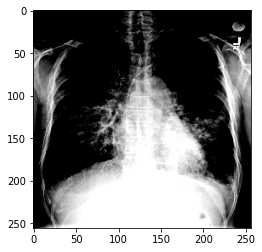

In [16]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [17]:
#train_generator.labels

In [18]:
df.groupby('label').count().values[:,0]

array([407, 128, 423])

In [19]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

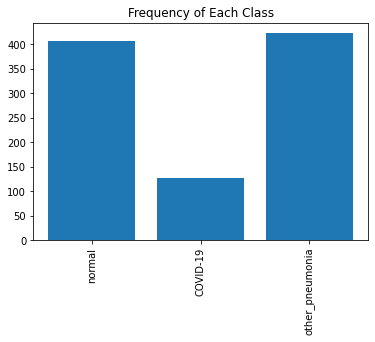

In [20]:
plt.xticks(rotation=90)
plt.bar(x=classes, height=df.groupby('label').count().values[:,0])
plt.title("Frequency of Each Class")
plt.show()

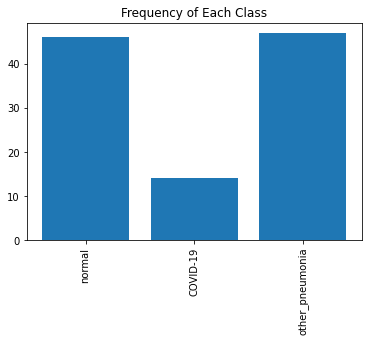

In [21]:
plt.xticks(rotation=90)
plt.bar(x=classes, height=val_df.groupby('label').count().values[:,0])
plt.title("Frequency of Each Class")
plt.show()

In [22]:
input_shape = (256,256,3)


In [23]:

def getModel():
    
    pretrained_model = Xception(input_shape = input_shape,
                weights = 'imagenet',
                layers=tf.keras.layers,
                include_top = False)
    pretrained_model.trainable = False
    pretrained_model.summary()
    
    for layer in pretrained_model.layers:
        layer.trainable = False
    
    model = Sequential()

    model.add(pretrained_model)

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.summary()
    return model

## Define EarlyStopping, ModelCheckpoint, TensorBoard

In [24]:

# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
patience=20)

mc = ModelCheckpoint(os.path.join(os.getcwd(), checkpints_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), monitor='val_accuracy', mode='max', verbose=1, save_best_only=False)
tb = TensorBoard(log_dir='./logs/'+logs)

In [25]:
mirrored_strategy = tf.distribute.MirroredStrategy()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [26]:
train_generator.samples

958

In [27]:
train_generator.batch_size

128

### Train the model in mirrored_strategy, Its take care run on multiple GPU's

In [28]:
with mirrored_strategy.scope():
    model = getModel()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    epochs = 20
    history = model.fit(train_generator,
                                  steps_per_epoch=train_generator.samples/train_generator.batch_size,
                                  epochs=epochs,
                                  validation_data=val_generator,
                                  validation_steps=val_generator.samples/val_generator.batch_size,
                                  callbacks=[es,mc,tb] )

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [29]:
!mkdir models

## Save the model

In [30]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = 'models'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
os.environ['export_path'] = export_path
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(
    model,
    export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = models/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/1/assets

Saved model:
total 3876
drwxr-xr-x 2 seq seq    4096 May  7 10:55 assets
-rw-rw-r-- 1 seq seq 3959051 May  7 10:55 saved_model.pb
drwxr-xr-x 2 seq seq    4096 May  7 10:55 variables


### View the saved model

In [31]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['xception_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: serving_default_xception_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['activation_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function